Quelques dates
Avant le 21/04 :
¤ Remise du rapport 
   - Entre 10 et 20 pages
   - Pas de code dans le rapport
   I: Introduction  (  (3))  (1-2pages)
   - Court
   - Résumer la tache effectuer par le RN (spécificités, votre approche, le plan)
   - Présenter l'état de l'art (ce qui a déja été fait) et si on s'en est inspiré
   II: Les données ( ensuite decrire les données (2)) (2 pages max)
   - Décrire les entrées/sorties ( nombre de taches abordées)
   - Statistique:
       - Taille des données train/test
       - Vocabulaire
       - Répartition classe
       - Filtrage / selection des données
   III: Le modéle ( Commencer par cette partie  (1) )   (5-6 pages)
   - Définir le modèle ( faire une figure illustrer)
   - Résultats/accuracy/courbe d'apprentissage (nombre d'époques, temps total, stratégie d'apprentissage utilisée)
       -  
   - Expliquer les coubres/diagrammes/tableaux
   
   
   IV: Conclusion (1 page)
   - Résumer de ce qui a été fait, et ce qui reste à faire, comment on pourrait le faire 
   
   Exemple bAbi task: Monde clos vocabulaire générer et fixes
   Important donner des exemples
Mercredi 26/04,  Vendredi 28/04,   Mardi 02/05
- Soutenance TER ( date encore à déterminer)
  20 minutes exposé/questions
 
 
 
 A rendre Rapport + code -> archive
 Rapport: nom.pdf
 Archive: nom.tgz/zip/rar
 
 A envoyer à l'adresse:
 allauzen@limsi.fr

In [1]:
'''Trains two recurrent neural networks based upon a story and a question.
The resulting merged vector is then queried to answer a range of bAbI tasks.
The results are comparable to those for an LSTM model provided in Weston et al.:
"Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks"
http://arxiv.org/abs/1502.05698
Task Number                  | FB LSTM Baseline | Keras QA
---                          | ---              | ---
QA1 - Single Supporting Fact | 50               | 100.0
QA2 - Two Supporting Facts   | 20               | 50.0
QA3 - Three Supporting Facts | 20               | 20.5
QA4 - Two Arg. Relations     | 61               | 62.9
QA5 - Three Arg. Relations   | 70               | 61.9
QA6 - Yes/No Questions       | 48               | 50.7
QA7 - Counting               | 49               | 78.9
QA8 - Lists/Sets             | 45               | 77.2
QA9 - Simple Negation        | 64               | 64.0
QA10 - Indefinite Knowledge  | 44               | 47.7
QA11 - Basic Coreference     | 72               | 74.9
QA12 - Conjunction           | 74               | 76.4
QA13 - Compound Coreference  | 94               | 94.4
QA14 - Time Reasoning        | 27               | 34.8
QA15 - Basic Deduction       | 21               | 32.4
QA16 - Basic Induction       | 23               | 50.6
QA17 - Positional Reasoning  | 51               | 49.1
QA18 - Size Reasoning        | 52               | 90.8
QA19 - Path Finding          | 8                | 9.0
QA20 - Agent's Motivations   | 91               | 90.7
For the resources related to the bAbI project, refer to:
https://research.facebook.com/researchers/1543934539189348
Notes:
- With default word, sentence, and query vector sizes, the GRU model achieves:
  - 100% test accuracy on QA1 in 20 epochs (2 seconds per epoch on CPU)
  - 50% test accuracy on QA2 in 20 epochs (16 seconds per epoch on CPU)
In comparison, the Facebook paper achieves 50% and 20% for the LSTM baseline.
- The task does not traditionally parse the question separately. This likely
improves accuracy and is a good example of merging two RNNs.
- The word vector embeddings are not shared between the story and question RNNs.
- See how the accuracy changes given 10,000 training samples (en-10k) instead
of only 1000. 1000 was used in order to be comparable to the original paper.
- Experiment with GRU, LSTM, and JZS1-3 as they give subtly different results.
- The length and noise (i.e. 'useless' story components) impact the ability for
LSTMs / GRUs to provide the correct answer. Given only the supporting facts,
these RNNs can achieve 100% accuracy on many tasks. Memory networks and neural
networks that use attentional processes can efficiently search through this
noise to find the relevant statements, improving performance substantially.
This becomes especially obvious on QA2 and QA3, both far longer than QA1.
'''

from __future__ import print_function
from functools import reduce
import re
import tarfile

import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Merge, Dropout, RepeatVector
from keras.layers import recurrent
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the relMAated substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file, retrieve the stories, and then convert the sentences into a single story.
    If max_length is supplied, any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        y = np.zeros(len(word_idx) + 1)  # let's not forget that index 0 is reserved
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return pad_sequences(X, maxlen=story_maxlen), pad_sequences(Xq, maxlen=query_maxlen), np.array(Y)

RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 50
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 40
print('RNN / Embed / Sent / Query = {}, {}, {}, {}'.format(RNN, EMBED_HIDDEN_SIZE, SENT_HIDDEN_SIZE, QUERY_HIDDEN_SIZE))

try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise
tar = tarfile.open(path)
# Default QA1 with 1000 samples
# challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'
challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
# QA1 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
# QA2 with 1000 samples
# challenge = 'tasks_1-20_v1-2/en/qa2_two-supporting-facts_{}.txt'
# QA2 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'
train = get_stories(tar.extractfile(challenge.format('train')))
test = get_stories(tar.extractfile(challenge.format('test')))

vocab = sorted(reduce(lambda x, y: x | y, (set(story + q + [answer]) for story, q, answer in train + test)))
# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
story_maxlen = max(map(len, (x for x, _, _ in train + test)))
query_maxlen = max(map(len, (x for _, x, _ in train + test)))

X, Xq, Y    = vectorize_stories(train, word_idx, story_maxlen, query_maxlen)
tX, tXq, tY = vectorize_stories( test, word_idx, story_maxlen, query_maxlen)

print('vocab = {}'.format(vocab))
print('X.shape = {}'.format(X.shape))
print('Xq.shape = {}'.format(Xq.shape))
print('Y.shape = {}'.format(Y.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))
print('Build model...')

qrnn = Sequential()
qrnn.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE,
                   input_length=query_maxlen))

qrnn.add(Dropout(0.3))
qrnn.add(RNN(EMBED_HIDDEN_SIZE, return_sequences=False))

qrnn.add(RepeatVector(story_maxlen))

sentrnn = Sequential()
sentrnn.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE,
                      input_length=story_maxlen))
sentrnn.add(Dropout(0.3))

model = Sequential()
model.add(Merge([sentrnn, qrnn], mode='sum'))
model.add(RNN(EMBED_HIDDEN_SIZE, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Training')
history = model.fit([X, Xq], Y, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, validation_split=0.05)
loss, acc = model.evaluate([tX, tXq], tY, batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("%s: %.2f%%" % (model.metrics_names[1], acc*100))
best = acc * 100
# supportingFacts false
# 10 k 
# 40 epochs

Using Theano backend.


RNN / Embed / Sent / Query = <class 'keras.layers.recurrent.LSTM'>, 50, 100, 100
vocab = [u'.', u'?', u'Daniel', u'John', u'Mary', u'Sandra', u'Where', u'back', u'bathroom', u'bedroom', u'garden', u'hallway', u'is', u'journeyed', u'kitchen', u'moved', u'office', u'the', u'to', u'travelled', u'went']
X.shape = (10000, 68)
Xq.shape = (10000, 4)
Y.shape = (10000, 22)
story_maxlen, query_maxlen = 68, 4
Build model...
Training
Train on 9500 samples, validate on 500 samples
Epoch 1/40
9500/9500 [==============================] - 56s - loss: 1.8661 - acc: 0.2416 - val_loss: 1.5454 - val_acc: 0.4420
Epoch 2/40
9500/9500 [==============================] - 56s - loss: 1.4270 - acc: 0.4731 - val_loss: 1.3776 - val_acc: 0.4940
Epoch 3/40
9500/9500 [==============================] - 56s - loss: 1.2909 - acc: 0.5101 - val_loss: 1.2513 - val_acc: 0.5240
Epoch 4/40
9500/9500 [==============================] - 56s - loss: 1.2167 - acc: 0.5131 - val_loss: 1.1961 - val_acc: 0.4900
Epoch 5/40
9500/9500 [=

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 68, 50)        1100                                         
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 68, 50)        0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 4, 50)         1100                                         
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 4, 50)         0                                            
___________________________________________________________________________________________

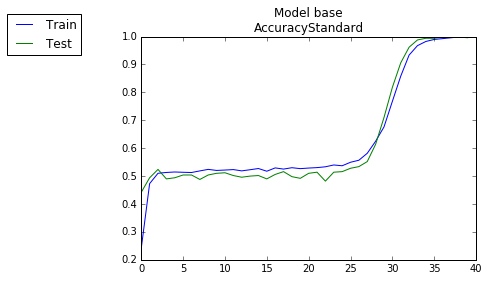

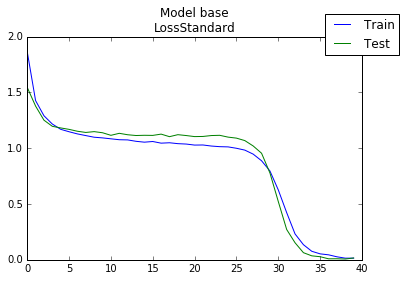

In [5]:
from matplotlib import pyplot as p
%matplotlib inline
model.summary()
print (history.params)

x = history.epoch
y_acc = history.history["acc"]
y_accVal = history.history['val_acc']

p.plot(x, y_acc, label='Train')
p.plot(x, y_accVal, label='Test')
p.legend(bbox_to_anchor=(0, 1),
           bbox_transform=p.gcf().transFigure)
title = 'Model base' + '\nAccuracy' + 'Standard'
p.title(title)

p.show()

y_loss = history.history["loss"]
y_lossVal = history.history['val_loss']
p.plot(x, y_loss, label='Train')
p.plot(x, y_lossVal, label='Test')
p.legend(bbox_to_anchor=(1, 1),
           bbox_transform=p.gcf().transFigure)
title1 = 'Model base' + '\nLoss' + 'Standard'
p.title(title1)

p.show()

In [29]:
qrnn2 = Sequential()
qrnn2.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE,
                   input_length=query_maxlen))

qrnn2.add(Dropout(0.3))
qrnn2.add(RNN(EMBED_HIDDEN_SIZE, return_sequences=False))
qrnn2.add(Dense(EMBED_HIDDEN_SIZE, activation='relu'))
qrnn2.add(RepeatVector(story_maxlen))

sentrnn2 = Sequential()
sentrnn2.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE,
                      input_length=story_maxlen))
sentrnn2.add(Dropout(0.3))

model2 = Sequential()
model2.add(Merge([sentrnn, qrnn], mode='sum'))
model2.add(RNN(EMBED_HIDDEN_SIZE, return_sequences=False))
model2.add(Dropout(0.3))
model2.add(Dense(vocab_size, activation='softmax'))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Training')
history2 = model2.fit([X, Xq], Y, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, validation_split=0.05)
loss, acc = model2.evaluate([tX, tXq], tY, batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("%s: %.2f%%" % (model2.metrics_names[1], acc*100))
if (acc*100) < best:
    print(" Not the best !")
else:
    print(" We found a winner !")

Training
Train on 950 samples, validate on 50 samples
Epoch 1/40
950/950 [==============================] - 5s - loss: 2.5647 - acc: 0.1716 - val_loss: 2.0381 - val_acc: 0.3600
Epoch 2/40
950/950 [==============================] - 5s - loss: 1.9362 - acc: 0.2232 - val_loss: 1.7080 - val_acc: 0.5000
Epoch 3/40
950/950 [==============================] - 5s - loss: 1.7239 - acc: 0.3147 - val_loss: 1.6268 - val_acc: 0.4200
Epoch 4/40
950/950 [==============================] - 5s - loss: 1.6080 - acc: 0.4042 - val_loss: 1.4475 - val_acc: 0.5200
Epoch 5/40
950/950 [==============================] - 5s - loss: 1.4499 - acc: 0.4853 - val_loss: 1.4716 - val_acc: 0.4600
Epoch 6/40
950/950 [==============================] - 5s - loss: 1.4183 - acc: 0.5053 - val_loss: 1.3427 - val_acc: 0.5000
Epoch 7/40
950/950 [==============================] - 5s - loss: 1.3357 - acc: 0.5389 - val_loss: 1.3182 - val_acc: 0.5000
Epoch 8/40
950/950 [==============================] - 5s - loss: 1.2522 - acc: 0.5495

In [8]:
model2.summary()
print (history2.params)

y_acc2 = history2.history["acc"]
y_accVal2 = history2.history['val_acc']

p.plot(x, y_acc2, label='Train')
p.plot(x, y_accVal2, label='Test')
p.legend(bbox_to_anchor=(1, 1),
           bbox_transform=p.gcf().transFigure)
title = 'Model LSTM + Dense relu' + '\nAccuracy' + '\nStandard'
p.title(title)
p.title(title1)
p.show()

y_loss2 = history2.history["loss"]
y_lossVal2 = history2.history['val_loss']
p.plot(x, y_loss2, label='Train')
p.plot(x, y_lossVal2, label='Test')
p.legend(bbox_to_anchor=(1, 1),
           bbox_transform=p.gcf().transFigure)
title1 = 'Model LSTM + Dense relu' + '\nLoss' + '\nStandard'
p.title(title)

p.show()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 66, 50)        1100                                         
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 66, 50)        0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 4, 50)         1100                                         
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 4, 50)         0                                            
___________________________________________________________________________________________

In [12]:
# print([key for key in word_idx.keys() if word_idx[key] == 9])

In [22]:
RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 50
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 16
EPOCHS = 50


qrnn3 = Sequential()
qrnn3.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE,
                   input_length=query_maxlen))

qrnn3.add(Dropout(0.3))
qrnn3.add(RNN(EMBED_HIDDEN_SIZE, return_sequences=False))
qrnn3.add(RepeatVector(story_maxlen))

sentrnn3 = Sequential()
sentrnn3.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE,
                      input_length=story_maxlen))
sentrnn3.add(Dropout(0.3))

model3 = Sequential()
model3.add(Merge([sentrnn, qrnn], mode='sum'))
model3.add(RNN(EMBED_HIDDEN_SIZE, return_sequences=False))
model3.add(Dropout(0.3))
model3.add(Dense(vocab_size, activation='softmax'))

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Training')
history3 = model3.fit([X, Xq], Y, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, validation_split=0.05)
loss, acc = model3.evaluate([tX, tXq], tY, batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("%s: %.2f%%" % (model3.metrics_names[1], acc*100))

if (acc*100) < best:
    print(" Not the best !")
else:
    print(" We found a winner !")

Training
Train on 950 samples, validate on 50 samples
Epoch 1/50
950/950 [==============================] - 5s - loss: 2.6023 - acc: 0.1547 - val_loss: 1.8717 - val_acc: 0.2800
Epoch 2/50
950/950 [==============================] - 5s - loss: 1.8166 - acc: 0.2516 - val_loss: 1.6293 - val_acc: 0.5000
Epoch 3/50
950/950 [==============================] - 6s - loss: 1.6664 - acc: 0.3537 - val_loss: 1.5960 - val_acc: 0.5000
Epoch 4/50
950/950 [==============================] - 5s - loss: 1.5646 - acc: 0.4263 - val_loss: 1.4819 - val_acc: 0.5000
Epoch 5/50
950/950 [==============================] - 5s - loss: 1.5077 - acc: 0.4695 - val_loss: 1.4312 - val_acc: 0.5000
Epoch 6/50
950/950 [==============================] - 5s - loss: 1.4714 - acc: 0.4768 - val_loss: 1.3753 - val_acc: 0.5400
Epoch 7/50
950/950 [==============================] - 5s - loss: 1.4089 - acc: 0.5074 - val_loss: 1.4167 - val_acc: 0.5000
Epoch 8/50
950/950 [==============================] - 5s - loss: 1.3740 - acc: 0.5084

In [20]:
model3.summary()
print (history3.params)

y_acc3 = history3.history["acc"]
y_accVal3 = history3.history['val_acc']

p.plot(x,y_acc3, label='Train')
p.plot(x,y_accVal3, label='Test')
p.legend(bbox_to_anchor=(1, -1),
           bbox_transform=p.gcf().transFigure)
title = 'Model LSTM + Dense relu' + '\nAccuracy' + '\nEMBED_HIDDEN_SIZE = 100'
p.title(title)

p.show()

y_loss3 = history3.history["loss"]
y_lossVal3 = history3.history['val_loss']
p.plot(x, y_loss3, label='Train')
p.plot(x, y_lossVal3, label='Test')
p.legend(bbox_to_anchor=(1, -1),
           bbox_transform=p.gcf().transFigure)
title = 'Model LSTM + Dense relu' + '\nLoss'  + '\nEMBED_HIDDEN_SIZE = 100'
p.title(title)

p.show()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 66, 50)        1100                                         
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 66, 50)        0                                            
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 66, 50)        0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 4, 50)         1100                                         
___________________________________________________________________________________________

In [ ]:
# Find the supporting ! RN which  have to learn where is the answer
#
RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 50
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 16
EPOCHS = 50


qrnn4 = Sequential()
qrnn4.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE,
                   input_length=query_maxlen))

qrnn4.add(Dropout(0.3))
qrnn4.add(RNN(EMBED_HIDDEN_SIZE, return_sequences=False))
qrnn4.add(RepeatVector(story_maxlen))

sentrnn4 = Sequential()
sentrnn4.add(Embedding(vocab_size, EMBED_HIDDEN_SIZE,
                      input_length=story_maxlen))
sentrnn4.add(Dropout(0.3))

model4 = Sequential()
model4.add(Merge([sentrnn, qrnn], mode='sum'))
model4.add(RNN(EMBED_HIDDEN_SIZE, return_sequences=False))
model4.add(Dropout(0.3))
model4.add(Dense(vocab_size, activation='softmax'))

# For a multi-class classification problem
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print('Training')
history4 = model4.fit([X, Xq], Y, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, validation_split=0.05)
loss, acc = model4.evaluate([tX, tXq], tY, batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))
print("%s: %.2f%%" % (model4.metrics_names[1], acc*100))

if (acc*100) < best:
    print(" Not the best !")
else:
    print(" We found a winner !")

In [ ]:
model4.summary()
print (history4.params)

y_acc4 = history4.history["acc"]
y_accVal4 = history4.history['val_acc']

p.plot(x,y_acc4, label='Train')
p.plot(x,y_accVal4, label='Test')
p.legend(bbox_to_anchor=(1, -1),
           bbox_transform=p.gcf().transFigure)
title = 'Model LSTM + Dense relu' + '\nAccuracy' + '\nEMBED_HIDDEN_SIZE = 100'
p.title(title)

p.show()

y_loss4 = history4.history["loss"]
y_lossVal4 = history4.history['val_loss']
p.plot(x, y_loss4, label='Train')
p.plot(x, y_lossVal4, label='Test')
p.legend(bbox_to_anchor=(1, -1),
           bbox_transform=p.gcf().transFigure)
title = 'Model LSTM + Dense relu' + '\nLoss'  + '\nEMBED_HIDDEN_SIZE = 100'
p.title(title)

p.show()